## Image Preprocessing

In [1]:
import argparse
import numpy as np
from collections import namedtuple

import torch
from torch import nn
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 96
image_size = 256
learning_rate = 1e-2
variation_weight = 30
epochs = 2500
layer_weight = [0.5, 1.0, 1.5, 3.0, 4.0]

np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
num_style = '01'
num_content = '01'

In [5]:
loc_style= "/content/drive/MyDrive/Colab Notebooks/style_transfer/style/style" + num_style + ".jpg"
loc_content = "/content/drive/MyDrive/Colab Notebooks/style_transfer/content/content" + num_content + ".jpg"

style_image = Image.open(loc_style)
content_image = Image.open(loc_content)
result_image = np.random.rand(256, 256, 3) * 255
result_image = Image.fromarray(result_image.astype('uint8'))

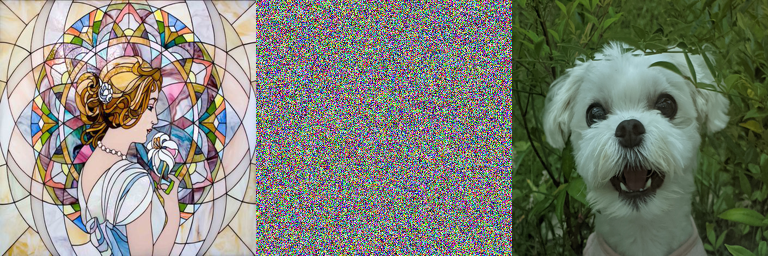

In [6]:
combined = Image.new("RGB", (image_size*3, image_size))
combined.paste(style_image.resize((image_size, image_size)), (0, 0))
combined.paste(result_image, (image_size, 0))
combined.paste(content_image.resize((image_size, image_size)), (image_size*2, 0))
display(combined)

In [7]:
# rgb2bgr? / normalize? / [0.0, 1.0] -> [0, 255]?
transform = transforms.Compose([transforms.Resize((image_size, image_size)),
                                transforms.ToTensor()#,  # [0.0, 1.0]
                                # transforms.Lambda(lambda x: x.mul(255))
                                ])


# Model

In [8]:
class VGG(nn.Module):
    def __init__(self, required_grad=False):
        super(VGG, self).__init__()
        vgg_pretrained = models.vgg19(pretrained=True).features

        # MaxPooling -> AvgPooling
        idx_pooling = [4, 9, 18, 27, 36]
        for idx in idx_pooling:
            vgg_pretrained[idx] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)

        # output
        self.conv1_1 = nn.Sequential()
        self.conv2_1 = nn.Sequential()
        self.conv3_1 = nn.Sequential()
        self.conv4_1 = nn.Sequential()
        self.conv5_1 = nn.Sequential()

        for x in range(2):
            self.conv1_1.add_module(str(x), vgg_pretrained[x])
        for x in range(2, 7):
            self.conv2_1.add_module(str(x), vgg_pretrained[x])
        for x in range(7, 12):
            self.conv3_1.add_module(str(x), vgg_pretrained[x])
        for x in range(12, 21):
            self.conv4_1.add_module(str(x), vgg_pretrained[x])
        for x in range(21, 30):
            self.conv5_1.add_module(str(x), vgg_pretrained[x])

        # don't do train
        if not required_grad:
            for param in self.parameters():
                param.required_grad = False

    def forward(self, x):
        conv1_1 = self.conv1_1(x)
        conv2_1 = self.conv2_1(conv1_1)
        conv3_1 = self.conv3_1(conv2_1)
        conv4_1 = self.conv4_1(conv3_1)
        conv5_1 = self.conv5_1(conv4_1)
        vgg_output = namedtuple("vgg_output", ['conv1_1', 'conv2_1', 'conv3_1',
                                               'conv4_1', 'conv5_1'])
        output = vgg_output(conv1_1, conv2_1, conv3_1, conv4_1, conv5_1)
        return output



# Loss

In [9]:
class ContentLoss(nn.Module):
    def __init__(self, content_feature, layer_weight):
        super(ContentLoss, self).__init__()
        self.content = content_feature
        self.weight = layer_weight

    def forward(self, x):
        loss_method = nn.MSELoss()
        x_len = len(x)
        loss_total = torch.tensor(0.0, requires_grad=True)

        for layer_idx in range(x_len):
            loss_total = loss_total + loss_method(x[layer_idx], self.content[layer_idx]) * self.weight[layer_idx]
        loss_total = loss_total / 2

        return loss_total

In [10]:
class StyleLoss(nn.Module):
    def __init__(self, style_feature, layer_weight):
        super(StyleLoss, self).__init__()
        self.style = style_feature
        self.weight = layer_weight

    def gram_matrix(self, x):
        b, ch, h, w = x.shape
        x = x.view(b, ch, h*w)
        x_t = x.transpose(1, 2)
        gram = x.bmm(x_t)
        return gram

    def forward(self, x):
        x_len = len(x)
        loss_total = torch.tensor(0.0, requires_grad=True)
        loss_method = nn.MSELoss()

        for layer_idx in range(x_len):
            style_gram = self.gram_matrix(self.style[layer_idx])
            x_gram = self.gram_matrix(x[layer_idx])

            b, ch, h, w = x[layer_idx].shape
            loss_layer = loss_method(x_gram, style_gram) / (4 * ch**2 * (h*w)**2)
            loss_total = loss_total + (loss_layer/x_len) * self.weight[layer_idx]

        return loss_total

In [11]:
def total_variation_loss(img):
     bs_img, c_img, h_img, w_img = img.size()
     tv_h = torch.pow(img[:,:,1:,:]-img[:,:,:-1,:], 2).sum()
     tv_w = torch.pow(img[:,:,:,1:]-img[:,:,:,:-1], 2).sum()
     return (tv_h+tv_w)/(bs_img*c_img*h_img*w_img)

# train

In [12]:
content_weight = 1e2
style_weight = 1e9

In [13]:
vgg = VGG(required_grad=False).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [14]:
# content, style 이미지의 경우 변하지 않으니 미리 feature map 값을 구할 수 있다.
style_image = Image.open(loc_style)
style_feature = transform(style_image).repeat(1, 1, 1, 1).to(device)
style_feature = vgg(style_feature)

content_image = Image.open(loc_content)
content_feature = transform(content_image).repeat(1, 1, 1, 1).to(device)
content_feature = vgg(content_feature)


In [15]:
print(style_feature.conv1_1.shape)
print(style_feature.conv2_1.shape)
print(style_feature.conv3_1.shape)
print(style_feature.conv4_1.shape)
print(style_feature.conv5_1.shape)

torch.Size([1, 64, 256, 256])
torch.Size([1, 128, 128, 128])
torch.Size([1, 256, 64, 64])
torch.Size([1, 512, 32, 32])
torch.Size([1, 512, 16, 16])


In [16]:
result_image = np.random.rand(256, 256, 3) * 255
result_image = Image.fromarray(result_image.astype('uint8'))

# set loss
x = transform(result_image).repeat(1, 1, 1, 1).to(device)
style = StyleLoss(style_feature, layer_weight)
content = ContentLoss(content_feature, layer_weight)

x = Variable(x, requires_grad=True)
optimizer = torch.optim.Adam([x], lr=learning_rate)
print(x.max())

tensor(0.9961, device='cuda:0', grad_fn=<MaxBackward1>)


In [17]:
interval = 50
history = {'content':[], 'style':[], 'total':[]}

In [18]:
# train
for epoch in range(epochs):
    # model
    result = vgg(x)
    
    # loss
    style_loss = style(result) * style_weight
    content_loss = content(result) * content_weight
    variation_loss = variation_weight * total_variation_loss(x)

    loss = style_loss + content_loss + variation_loss

    if epoch % interval == 0:
      print('-'*20)
      print('Epoch : ', epoch)
      print('content : {:.5} / style : {:.5} / variation : {:.5} / total {:.5}'.format(content_loss.item(),
                                                                                       style_loss.item(),
                                                                                       variation_loss.item(),
                                                                                       loss.item()))
    history['content'].append(content_loss.item())
    history['style'].append(style_loss.item())
    history['total'].append(loss.item())

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()


--------------------
Epoch :  0
content : 140.76 / style : 456.29 / variation : 9.9243 / total 606.97
--------------------
Epoch :  50
content : 115.44 / style : 60.149 / variation : 7.43 / total 183.02
--------------------
Epoch :  100
content : 88.26 / style : 37.754 / variation : 5.8354 / total 131.85
--------------------
Epoch :  150
content : 75.673 / style : 33.284 / variation : 4.6332 / total 113.59
--------------------
Epoch :  200
content : 68.746 / style : 31.968 / variation : 3.7023 / total 104.42
--------------------
Epoch :  250
content : 64.704 / style : 31.432 / variation : 2.9867 / total 99.123
--------------------
Epoch :  300
content : 62.175 / style : 31.089 / variation : 2.4502 / total 95.715
--------------------
Epoch :  350
content : 60.354 / style : 30.957 / variation : 2.057 / total 93.368
--------------------
Epoch :  400
content : 59.032 / style : 30.858 / variation : 1.7695 / total 91.66
--------------------
Epoch :  450
content : 58.053 / style : 30.819 / va

# Graph

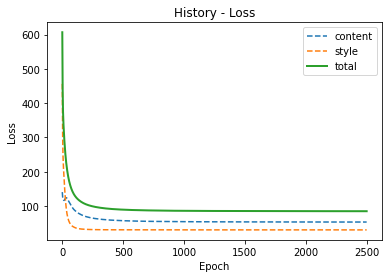

In [19]:
fig, ax = plt.subplots()
ax.plot(history['content'], label='content', linestyle='--')
ax.plot(history['style'], label='style', linestyle='--')
ax.plot(history['total'], label='total', linewidth=2)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('History - Loss')
ax.legend()

# Result

In [20]:
tf = transforms.ToPILImage()
result = tf(torch.squeeze(x.detach().cpu()))

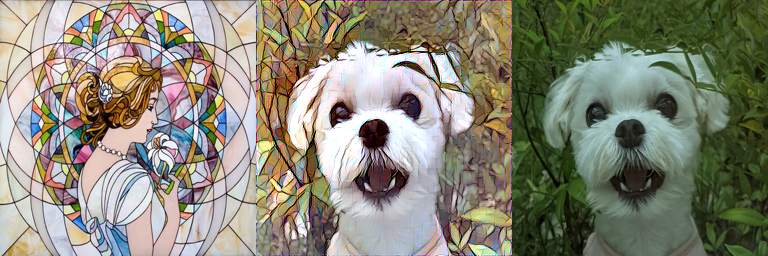

In [21]:
x = x.clamp(0, 1)
result = tf(torch.squeeze(x.detach().cpu()))
combined = Image.new("RGB", (image_size*3, image_size))
combined.paste(style_image.resize((image_size, image_size)), (0, 0))
combined.paste(result, (image_size, 0))
combined.paste(content_image.resize((image_size, image_size)), (image_size*2, 0))
display(combined)

# Save

In [22]:
fig.savefig("/content/drive/MyDrive/Colab Notebooks/style_transfer/history.png",
            dpi=300)

In [23]:
combined.save("/content/drive/MyDrive/Colab Notebooks/style_transfer/result/" + num_style + " X " + num_content + '_' + str(epochs) + ".png")

In [24]:
result.save("/content/drive/MyDrive/Colab Notebooks/style_transfer/result/" + num_style + " X " + num_content + '_result.png')